<a id='03-nb'></a>

# Music Recommender Part 3: Train Model with Debugger Hooks and Set Artifacts and Register Model

----
In this notebook, we'll train our model using the data we prepped with SageMaker Data Wrangler and stored in our Feature Store, attaching [SageMaker Debugger](https://docs.aws.amazon.com/sagemaker/latest/dg/train-debugger.html) to the model training so that we can capture training metrics/statistics about the model. Then, we'll log more model artifacts using [SageMaker ML Lineage Tracking](https://docs.aws.amazon.com/sagemaker/latest/dg/lineage-tracking.html). Finally we'll register the model and save its version.

A machine learning training job can have problems such as system bottlenecks, overfitting, saturated activation functions, and vanishing gradients, which can compromise model performance. SageMaker Debugger profiles and debugs training jobs to help resolve such problems and improve your ML model's compute resource utilization and performance. Debugger offers tools to send alerts when training anomalies are found, take actions against the problems, and identify the root cause of them by visualizing collected metrics and tensors.

Amazon SageMaker ML Lineage Tracking creates and stores information about the steps of a machine learning workflow from data preparation to model deployment. With the tracking information you can reproduce the workflow steps, track model and dataset lineage, and establish model governance and audit standards. 

<div class="alert alert-info"> 💡 <strong> Alert </strong>

For quicker data processing times, switch to at least an ml.m5.large (General Purpose) notebook instance or larger.
</div>

----
### Contents
- [Overview](00_overview_arch_data.ipynb)
- [Part 1: Data Prep using Data Wrangler](01_music_dataprep.flow)
- [Part 2a: Feature Store Creation - Tracks](02a_export_fg_tracks.ipynb)
- [Part 2b: Feature Store Creation - User Preferences](02b_export_fg_5star_features.ipynb)
- [Part 2c: Feature Store Creation - Ratings](02c_export_fg_ratings.ipynb)
- [Part 3: Train Model with Debugger Hooks. Set Artifacts and Register Model.](03_train_model_lineage_registry_debugger.ipynb)
    - [Fetch Data from Feature Store](#03-feature-store)
    - [Split Data and Save to S3](#03-split)
    - [Train Model](#03-train)
    - [SageMaker Debugger Reports](#03-debugger)
    - [Set Lineage Artifacts](#03-lineage)
    - [Register Model](#03-register)
- [Part 4: Deploy Model & Inference using Online Feature Store](04_deploy_infer_explain.ipynb)
- [Part 5: Model Monitor](05_model_monitor.ipynb)
- [Part 6: SageMaker Pipelines](06_pipeline.ipynb)
- [Part 7: Resource Cleanup](07_clean_up.ipynb)

### Load stored variables
If you ran this notebook before, you may want to re-use the resources you aready created with AWS. Run the cell below to load any prevously created variables. You should see a print-out of the existing variables. If you don't see anything you may need to create them again or it may be your first time running this notebook.

In [36]:
!pip install -qU smdebug
!pip install pandas --upgrade

/opt/conda/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes


In [37]:
import time
import boto3
import argparse
import pandas as pd
import pathlib
import sagemaker
import glob

In [38]:
import sys
import pprint
sys.path.insert(1, './code')
from parameter_store import ParameterStore
ps = ParameterStore(verbose=False)

parameters = ps.read('music-rec')

In [39]:
dw_ecrlist = parameters['dw_ecrlist']
fg_name_ratings = parameters['fg_name_ratings']
fg_name_tracks = parameters['fg_name_tracks']
fg_name_user_preferences = parameters['fg_name_user_preferences']
flow_export_id = parameters['flow_export_id']
flow_s3_uri = parameters['flow_s3_uri']
pretrained_model_path = parameters['pretrained_model_path']
prefix = parameters['prefix']
bucket = parameters['bucket']
ratings_data_source = parameters['ratings_data_source']
tracks_data_source = parameters['tracks_data_source']

In [40]:
# SHAP can take some time to install, so we will only install if it doesn't exist already
try:
    import shap
except ModuleNotFoundError:
    !conda install -y -c conda-forge shap

In [41]:
region = boto3.Session().region_name
boto_session = boto3.Session(region_name=region)


sagemaker_client = boto_session.client(service_name='sagemaker', region_name=region)
sagemaker_session = sagemaker.session.Session(
    boto_session=boto_session,
    sagemaker_client=sagemaker_client
)
featurestore_runtime = boto_session.client(service_name='sagemaker-featurestore-runtime', region_name=region)

feature_store_session = sagemaker.session.Session(
    boto_session=boto_session,
    sagemaker_client=sagemaker_client,
    sagemaker_featurestore_runtime_client=featurestore_runtime
)

<a id='03-feature-store'></a>

## Fetch Data from Offline Feature Store

##### [back to top](#03-nb)

----
There are 3 feature stores for the ratings, tracks, and user preferences data. We retrieve data from all 3 before joining them.

In [42]:
from sagemaker.feature_store.feature_group import FeatureGroup

feature_group_names = [fg_name_ratings, fg_name_tracks, fg_name_user_preferences]
feature_groups = []
for name in feature_group_names:
    feature_group = FeatureGroup(name=name, sagemaker_session=feature_store_session)
    feature_groups.append(feature_group)

In [43]:
s3_client = boto3.client('s3')
account_id = boto3.client('sts').get_caller_identity()["Account"]

sagemaker_role = sagemaker.get_execution_role()

s3_output_path = 's3://' + bucket
ps.add({'s3_output_path': s3_output_path}, namespace='music-rec')

In [44]:
feature_group_s3_prefixes = []
for feature_group in feature_groups:
    feature_group_table_name = feature_group.describe().get("OfflineStoreConfig").get("DataCatalogConfig").get("TableName")
    feature_group_s3_prefix = f'{account_id}/sagemaker/{region}/offline-store/{feature_group_table_name}'
    feature_group_s3_prefixes.append(feature_group_s3_prefix)

In [45]:
# wait for data to be added to offline feature store
def wait_for_offline_store(feature_group_s3_prefix):
    print(feature_group_s3_prefix)
    offline_store_contents = None
    while (offline_store_contents is None):
        objects_in_bucket = s3_client.list_objects(Bucket=bucket, Prefix=feature_group_s3_prefix)
        if ('Contents' in objects_in_bucket and len(objects_in_bucket['Contents']) > 1):
            offline_store_contents = objects_in_bucket['Contents']
        else:
            print('Waiting for data in offline store...')
            time.sleep(60)
    print('Data available.')
    
for s3_prefix in feature_group_s3_prefixes:
    wait_for_offline_store(s3_prefix)

738335684114/sagemaker/us-east-2/offline-store/ratings-features-music-rec-1628141942
Data available.
738335684114/sagemaker/us-east-2/offline-store/track-features-music-rec-1628139447
Data available.
738335684114/sagemaker/us-east-2/offline-store/user-5star-track-features-music-rec-1628140890
Data available.


In [46]:
tables = { 
    'ratings': {'feature_group': feature_groups[0],
                'cols': ['userid', 'trackid', 'rating']
               },
    'tracks': {'feature_group': feature_groups[1],
                'cols': ['trackid', 'length', 'energy', 'acousticness', 'valence', 'speechiness', 'instrumentalness', 
                        'liveness', 'tempo', 'danceability', 'genre_latin', 'genre_folk', 'genre_blues', 'genre_rap', 
                        'genre_reggae', 'genre_jazz', 'genre_rnb', 'genre_country', 'genre_electronic', 'genre_pop_rock']
               },
    'user_5star_features': {'feature_group': feature_groups[2],
                            'cols': ['userid', 'energy_5star', 'acousticness_5star', 'valence_5star', 'speechiness_5star', 'instrumentalness_5star', 
                                    'liveness_5star','tempo_5star', 'danceability_5star', 'genre_latin_5star', 'genre_folk_5star', 'genre_blues_5star', 
                                    'genre_rap_5star','genre_reggae_5star', 'genre_jazz_5star', 'genre_rnb_5star', 'genre_country_5star', 
                                    'genre_electronic_5star', 'genre_pop_rock_5star']
                           },
  }

check if the athena queres have been done and the data sets exist, then just do train test split or just proceed to training

In [47]:
def get_train_val():
    for k, v in tables.items():
        query = v['feature_group'].athena_query()
        joined_cols = ", ".join(v['cols'])
        # limit number of datapoints for training time
        query_string = "SELECT {} FROM \"{}\" LIMIT 500000".format(joined_cols, query.table_name)
        print(query_string,'\n')

        output_location = f's3://{bucket}/{prefix}/query_results/'
        query.run(query_string=query_string, output_location=output_location)
        query.wait()

        tables[k]['df'] = query.as_dataframe()  
    
    ratings = tables['ratings']['df']
    tracks = tables['tracks']['df']
    user_prefs = tables['user_5star_features']['df']
    
    print('Merging datasets...')
    print(f'Ratings: {ratings.shape}\nTracks: {tracks.shape}\nUser Prefs: {user_prefs.shape}\n')
    
    dataset = pd.merge(ratings, tracks, on='trackid', how='inner')
    dataset = pd.merge(dataset, user_prefs, on='userid', how='inner')
    dataset.drop_duplicates(inplace=True)
    dataset.drop(['userid', 'trackid'], axis=1, inplace=True)

    # split data
    from sklearn.model_selection import train_test_split
    train, val = train_test_split(dataset, test_size=0.2, random_state=42)
    print("Training dataset shape: {}\nValidation dataset shape: {}\n".format(train.shape, val.shape))

    return train, val

In [48]:
%%time
import pandas as pd

# create the training data if it has not been created already
if glob.glob('data/train_data.csv') and 'feature_names' in parameters:
    print('Using existing files: train_data.csv & val_data.csv')
    train = pd.read_csv('data/train_data.csv', names=["rating"]+parameters['feature_names'])
    val = pd.read_csv('data/val_data.csv', names=["rating"]+parameters['feature_names'])
else:
    print('Creating training and validation sets...\n')
    train, val = get_train_val()
    # Write to csv in S3 without headers and index column
    train.to_csv('./data/train_data.csv', header=False, index=False)
    val.to_csv('./data/val_data.csv', header=False, index=False)

Creating training and validation sets...

SELECT userid, trackid, rating FROM "ratings-features-music-rec-1628141942" LIMIT 500000 

SELECT trackid, length, energy, acousticness, valence, speechiness, instrumentalness, liveness, tempo, danceability, genre_latin, genre_folk, genre_blues, genre_rap, genre_reggae, genre_jazz, genre_rnb, genre_country, genre_electronic, genre_pop_rock FROM "track-features-music-rec-1628139447" LIMIT 500000 

SELECT userid, energy_5star, acousticness_5star, valence_5star, speechiness_5star, instrumentalness_5star, liveness_5star, tempo_5star, danceability_5star, genre_latin_5star, genre_folk_5star, genre_blues_5star, genre_rap_5star, genre_reggae_5star, genre_jazz_5star, genre_rnb_5star, genre_country_5star, genre_electronic_5star, genre_pop_rock_5star FROM "user-5star-track-features-music-rec-1628140890" LIMIT 500000 

Merging datasets...
Ratings: (490020, 3)
Tracks: (98827, 20)
User Prefs: (258, 19)

Training dataset shape: (181824, 38)
Validation dataset

## Save data to S3

In [49]:
%%time
s3_client.upload_file('data/train_data.csv', bucket, f'{prefix}/data/train/train_data.csv')
s3_client.upload_file('data/val_data.csv', bucket, f'{prefix}/data/val/val_data.csv')


train_data_uri = f's3://{bucket}/{prefix}/data/train/train_data.csv'
val_data_uri = f's3://{bucket}/{prefix}/data/val/val_data.csv'
print (f"Saving training data to {train_data_uri}")

# configure data inputs for SageMaker training
from sagemaker.inputs import TrainingInput
train_input = TrainingInput(train_data_uri, content_type="text/csv")
val_input = TrainingInput(val_data_uri, content_type="text/csv")

Saving training data to s3://sagemaker-us-east-2-738335684114/music-recommendation/data/train/train_data.csv
CPU times: user 738 ms, sys: 617 ms, total: 1.35 s
Wall time: 1.47 s


In [50]:
ps.add({'train_data_uri': train_data_uri, 'val_data_uri': val_data_uri}, namespace='music-rec')
ps.store()

date and time = 05/08/2021 06:19:44


<a id='03-train'></a>

## Train Model 

##### [back to top](#03-nb)

----

In [51]:
from sagemaker.debugger import Rule, rule_configs
from sagemaker.debugger import DebuggerHookConfig, CollectionConfig
from sagemaker.estimator import Estimator

In [52]:
# variables used for parameterizing the notebook run
estimator_output_path = f's3://{bucket}/{prefix}/training_jobs'
train_instance_count = 2
train_instance_type = 'ml.m5.4xlarge'
save_interval = 2
image = sagemaker.image_uris.retrieve("xgboost", region, "0.90-2")
model_name = 'music-recommendation-model'
print(f"Created new model: {model_name}")

ps.add({'model_name':model_name}, namespace='music-rec')
ps.store()

hyperparameters = {
    "max_depth": "4",
    "eta": "0.2",
    "objective": "reg:squarederror",
    "num_round": "100",
}

Created new model: music-recommendation-model
date and time = 05/08/2021 06:19:44


In [53]:
xgb_estimator = Estimator(
    role=sagemaker_role,
    instance_count=train_instance_count,
    instance_type=train_instance_type,
    image_uri=image,
    hyperparameters=hyperparameters,
    base_job_name=model_name,
    output_path=estimator_output_path,
    
    debugger_hook_config=DebuggerHookConfig(
        s3_output_path=estimator_output_path+'/debugger',  
        collection_configs=[
            CollectionConfig(
                name="metrics",
                parameters={
                    "save_interval": str(save_interval)
                }
            ),
            CollectionConfig(
                name="feature_importance",
                parameters={
                    "save_interval": str(save_interval)
                }
            ),
            CollectionConfig(
                name="full_shap",
                parameters={
                    "save_interval": str(save_interval)
                }
            ),
            CollectionConfig(
                name="average_shap",
                parameters={
                    "save_interval": str(save_interval)
                }
            ),
        ],
    ),

    rules=[
        Rule.sagemaker(
            rule_configs.loss_not_decreasing(),
            rule_parameters={
                "collection_names": "metrics",
                "num_steps": str(save_interval * 2),
            },
        )
    ],
)

#### Train the model here in order to access SageMaker Debugger
or skip to the next notebook now to deploy a pretrained model

In [54]:
response = sagemaker_client.list_training_jobs(
    NameContains = model_name,
    StatusEquals = 'Completed',
    SortBy='CreationTime',
    SortOrder='Descending'
)
print (f"model_name : {model_name}")
pprint.pprint(response)


model_name : music-recommendation-model
{'NextToken': 'cIws2QhTXUIa8bi8WqnvV4N1YqMOHlD7jElQ14IwjIiM23XR+iTNwl0QRUs3sqoGPqYMA5Qz9DbA31zJ8Dtf785YU/1/Job3V3akido1KSDqHvVM65+T+fn0QQTY3Af9qLoiQgjgtAUoMVouRB8zFy+5mauEFB6p9hOi/xmhq39rQmE0ta/sk8S8wCquTPbxM9tzlgP2V/3vOcLWUqnb8TpprnRMILitznVPObm7fF8xyAHoy1W7sVnD9j0OkpSzNBElMLu+aYm4MUm3GmCMCPjK0PwxhAtvyLI2EcHYIX2vc45Hmk7fb4vUJsdMwZtTigDQzNz/KcYC520fI886CWmsKvcvBqP092bAprvRJwmLEytUcGunt95OFmLwDoUYjKLKuB8TjJK38AvfPA43yb4R/7ywf4WzZIaAZudZIZbKgc4sFYdZ7+ghT4dTa5IbJVrvVMGAGLur33MXvOZ387RMb8Ef5fDwnUr/hQ+85l43aHwoDaZBME92qi3kXFEkdX8ckC4NWsgRC5JWTxVsdd03enxmZZMpOl8SDJjjDsiewi3vcTRtWQAa9tJkhIog1F1AoT8Vfe7XZBZ3jcI+00vaCpUrsJ9nGw6MiiE4NyWbvPUhqj1BQGXoJhxixvckzQWrWes2FxedLxlZ',
 'ResponseMetadata': {'HTTPHeaders': {'content-length': '1361',
                                      'content-type': 'application/x-amz-json-1.1',
                                      'date': 'Thu, 05 Aug 2021 06:19:44 GMT',
                                      'x-amzn-requestid': '

In [55]:
"""
s3_debugger_output_path = xgb_estimator.latest_job_debugger_artifacts_path()

ps.add({'s3_debugger_output_path': s3_debugger_output_path}, namespace='music-rec')
ps.store()


xgb_estimator = Estimator.attach(training_job_name)
parameters = ps.read('music-rec')
s3_debugger_output_path = parameters['s3_debugger_output_path']
print (s3_debugger_output_path)
ps.add({'s3_debugger_output_path': s3_debugger_output_path}, namespace='music-rec')
ps.store()
"""

"\ns3_debugger_output_path = xgb_estimator.latest_job_debugger_artifacts_path()\n\nps.add({'s3_debugger_output_path': s3_debugger_output_path}, namespace='music-rec')\nps.store()\n\n\nxgb_estimator = Estimator.attach(training_job_name)\nparameters = ps.read('music-rec')\ns3_debugger_output_path = parameters['s3_debugger_output_path']\nprint (s3_debugger_output_path)\nps.add({'s3_debugger_output_path': s3_debugger_output_path}, namespace='music-rec')\nps.store()\n"

In [56]:
%%time

train_model = True # True if training a new model, False if wanting to use an existing estimator once you've already trained

if train_model:
    print('Training the model')
    xgb_estimator.fit(inputs = {'train': train_input, 'validation': val_input})
    s3_debugger_output_path = xgb_estimator.latest_job_debugger_artifacts_path()
    ps.add({'s3_debugger_output_path': s3_debugger_output_path}, namespace='music-rec')
    ps.store()
elif len(response['TrainingJobSummaries']) > 0:
    training_job_name = response['TrainingJobSummaries'][0]['TrainingJobName']
    xgb_estimator = Estimator.attach(training_job_name)
    parameters = ps.read('music-rec')
    s3_debugger_output_path = parameters['s3_debugger_output_path']
    print(f'Using estimator from completed training job: {training_job_name}\nwith debugger path {s3_debugger_output_path}')
else:
    print("No existing estimator found. You'll need to run as train = True")


Training the model
2021-08-05 06:19:44 Starting - Starting the training job...
2021-08-05 06:19:46 Starting - Launching requested ML instancesLossNotDecreasing: InProgress
ProfilerReport-1628144384: InProgress
...
2021-08-05 06:20:35 Starting - Preparing the instances for training.........
2021-08-05 06:22:14 Downloading - Downloading input data
2021-08-05 06:22:14 Training - Downloading the training image...
2021-08-05 06:22:41 Training - Training image download completed. Training in progress.INFO:sagemaker-containers:Imported framework sagemaker_xgboost_container.training
INFO:sagemaker-containers:Failed to parse hyperparameter objective value reg:squarederror to Json.
Returning the value itself
INFO:sagemaker-containers:No GPUs detected (normal if no gpus installed)
INFO:sagemaker_xgboost_container.training:Running XGBoost Sagemaker in algorithm mode
INFO:root:Determined delimiter of CSV input is ','
INFO:root:Determined delimiter of CSV input is ','
INFO:root:Determined delimiter 

In [57]:
training_job_name = xgb_estimator.latest_training_job.job_name
print(training_job_name)

ps.add({'training_job_name': training_job_name}, namespace='music-rec')
ps.store()

music-recommendation-model-2021-08-05-06-19-44-755
date and time = 05/08/2021 06:28:02


In [58]:
import pprint
training_job_info = sagemaker_client.describe_training_job(TrainingJobName=training_job_name)
pprint.pprint(f"{training_job_info}")

("{'TrainingJobName': 'music-recommendation-model-2021-08-05-06-19-44-755', "
 "'TrainingJobArn': "
 "'arn:aws:sagemaker:us-east-2:738335684114:training-job/music-recommendation-model-2021-08-05-06-19-44-755', "
 "'ModelArtifacts': {'S3ModelArtifacts': "
 "'s3://sagemaker-us-east-2-738335684114/music-recommendation/training_jobs/music-recommendation-model-2021-08-05-06-19-44-755/output/model.tar.gz'}, "
 "'TrainingJobStatus': 'Completed', 'SecondaryStatus': 'Completed', "
 "'HyperParameters': {'eta': '0.2', 'max_depth': '4', 'num_round': '100', "
 "'objective': 'reg:squarederror'}, 'AlgorithmSpecification': "
 "{'TrainingImage': "
 "'257758044811.dkr.ecr.us-east-2.amazonaws.com/sagemaker-xgboost:0.90-2-cpu-py3', "
 "'TrainingInputMode': 'File', 'MetricDefinitions': [{'Name': 'train:mae', "
 "'Regex': "
 "'.*\\\\[[0-9]+\\\\].*#011train-mae:([-+]?[0-9]*\\\\.?[0-9]+(?:[eE][-+]?[0-9]+)?).*'}, "
 "{'Name': 'validation:aucpr', 'Regex': "
 "'.*\\\\[[0-9]+\\\\].*#011validation-aucpr:([-+]?[0-9

<a id='03-debugger'></a>

## View SageMaker Debugger Reports

##### [back to top](#03-nb)

----

### Create the Trail for the Experiment uisng the Debugger to generate trial debug-output

See this explanation for more information : https://github.com/awslabs/sagemaker-debugger/blob/master/docs/analysis.md

In [59]:
%%time
from smdebug.trials import create_trial

try:
    trial = create_trial(s3_debugger_output_path)
except:
    parameters = ps.read('music-rec')
    s3_debugger_output_path = parameters['s3_debugger_output_path']
    print (f"s3_debugger_output_path: {s3_debugger_output_path}")
    trial = create_trial(s3_debugger_output_path)

[2021-08-05 06:28:02.798 datascience-1-0-ml-m5-large-27a18e5913a0722f7dcd623188d3:4299 INFO s3_trial.py:42] Loading trial debug-output at path s3://sagemaker-us-east-2-738335684114/music-recommendation/training_jobs/debugger/music-recommendation-model-2021-08-05-06-19-44-755/debug-output
CPU times: user 409 ms, sys: 7.01 ms, total: 416 ms
Wall time: 1.94 s


In [60]:
feature_names = list(train.drop('rating', axis=1).columns)
print(feature_names)

ps.add({'feature_names': feature_names}, namespace='music-rec')
ps.store()

['length', 'energy', 'acousticness', 'valence', 'speechiness', 'instrumentalness', 'liveness', 'tempo', 'danceability', 'genre_latin', 'genre_folk', 'genre_blues', 'genre_rap', 'genre_reggae', 'genre_jazz', 'genre_rnb', 'genre_country', 'genre_electronic', 'genre_pop_rock', 'energy_5star', 'acousticness_5star', 'valence_5star', 'speechiness_5star', 'instrumentalness_5star', 'liveness_5star', 'tempo_5star', 'danceability_5star', 'genre_latin_5star', 'genre_folk_5star', 'genre_blues_5star', 'genre_rap_5star', 'genre_reggae_5star', 'genre_jazz_5star', 'genre_rnb_5star', 'genre_country_5star', 'genre_electronic_5star', 'genre_pop_rock_5star']
date and time = 05/08/2021 06:28:04


In [61]:
from itertools import islice
import matplotlib.pyplot as plt
import re

MAX_PLOTS = 35

def get_data(trial, tname):
    """
    For the given tensor name, walks though all the iterations
    for which you have data and fetches the values.
    Returns the set of steps and the values.
    """
    tensor = trial.tensor(tname)
    steps = tensor.steps()
    vals = [tensor.value(s) for s in steps]
    return steps, vals

def match_tensor_name_with_feature_name(tensor_name, feature_names=feature_names):
    feature_tag = tensor_name.split("/")
    for ifeat, feature_name in enumerate(feature_names):
        if feature_tag[-1]=="f{}".format(str(ifeat)): return feature_name
    return tensor_name


def plot_collection(trial, collection_name, regex='.*', figsize=(8, 6)):
    """
    Takes a `trial` and a collection name, and 
    plots all tensors that match the given regex.
    """
    fig, ax = plt.subplots(figsize=figsize)
    tensors = (trial.collection(collection_name).tensor_names)
    matched_tensors = [t for t in tensors if re.match(regex, t)]
    for tensor_name in islice(matched_tensors, MAX_PLOTS):
        steps, data = get_data(trial, tensor_name)
        ax.plot(steps, data, label=match_tensor_name_with_feature_name(tensor_name))

    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    ax.set_xlabel('Iteration')

[2021-08-05 06:28:04.989 datascience-1-0-ml-m5-large-27a18e5913a0722f7dcd623188d3:4299 INFO trial.py:198] Training has ended, will refresh one final time in 1 sec.
[2021-08-05 06:28:06.009 datascience-1-0-ml-m5-large-27a18e5913a0722f7dcd623188d3:4299 INFO trial.py:210] Loaded all steps


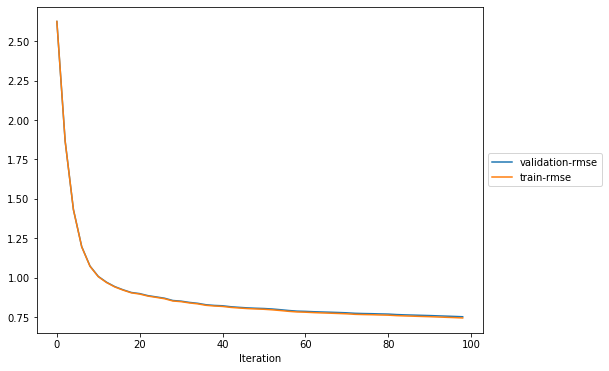

In [62]:
plot_collection(trial, "metrics")

In [63]:
def plot_feature_importance(trial, importance_type="weight"):
    SUPPORTED_IMPORTANCE_TYPES = [
        "weight", "gain", "cover", "total_gain", "total_cover"]
    if importance_type not in SUPPORTED_IMPORTANCE_TYPES:
        raise ValueError(
            f"{importance_type} is not one of the supported importance types.")
    plot_collection(
        trial,
        "feature_importance",
        regex=f"feature_importance/{importance_type}/.*")

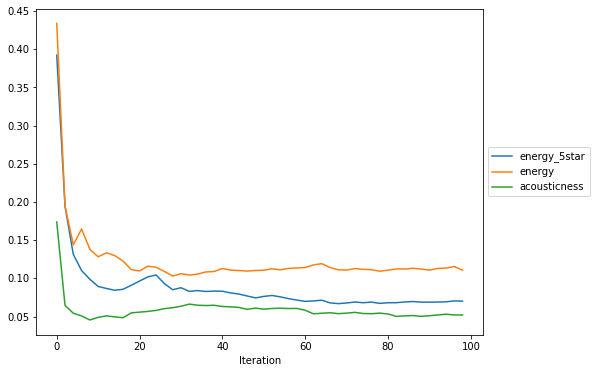

In [64]:
plot_feature_importance(trial, importance_type="gain")

### SHAP

[SHAP](https://github.com/slundberg/shap) (SHapley Additive exPlanations) is another approach to explain the output of machine learning models.
SHAP values represent a feature's contribution to a change in the model output. You instructed Estimator to log the average SHAP values in this example so the SHAP values (as calculated by [xgboost.predict(pred_contribs=True)](https://xgboost.readthedocs.io/en/latest/python/python_api.html#xgboost.Booster.predict)) will be available the `average_shap` collection.
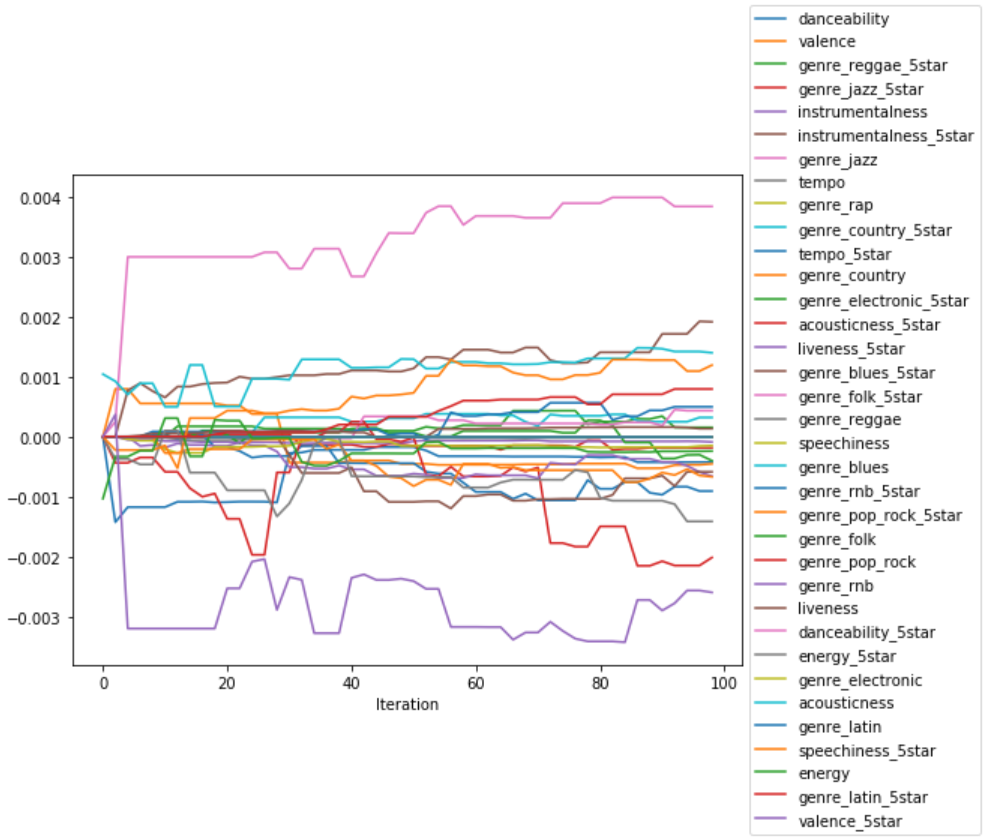

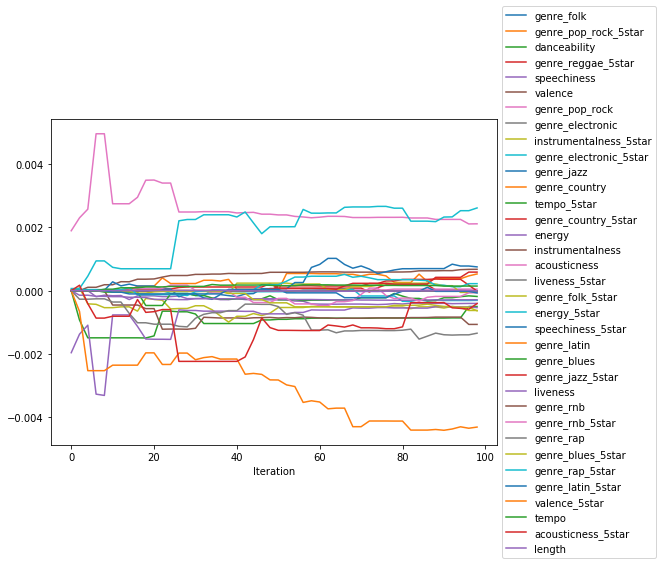

In [65]:
plot_collection(trial, "average_shap")

### Global explanations

Global explanatory methods allow understanding the model and its feature contributions in aggregate over multiple datapoints. Here we show an aggregate bar plot that plots the mean absolute SHAP value for each feature. 
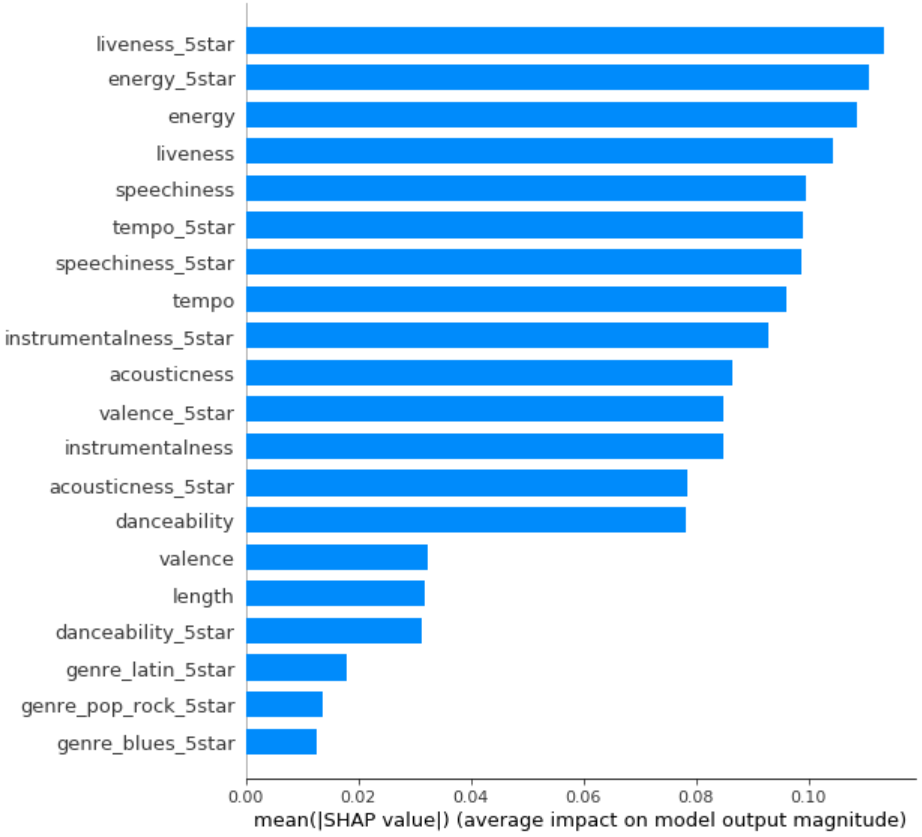

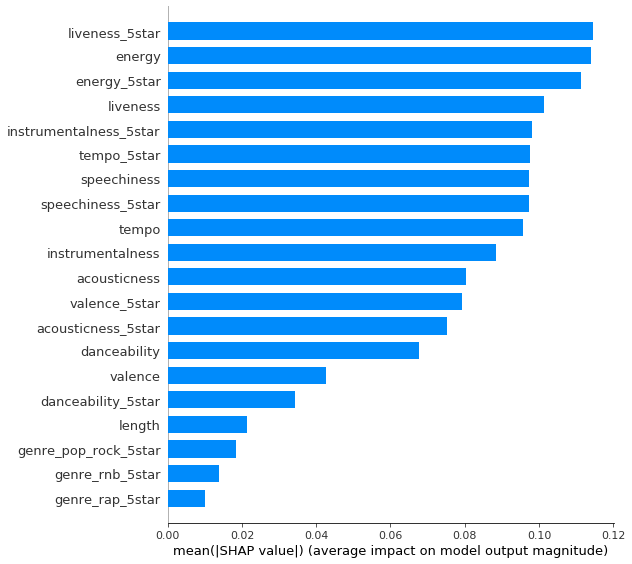

In [66]:
import shap

shap_values = trial.tensor("full_shap/f0").value(trial.last_complete_step)
shap_no_base = shap_values[:, :-1]
shap_base_value = shap_values[0, -1]
shap.summary_plot(shap_no_base, plot_type='bar', feature_names=feature_names)

In [67]:
shap_base_value

3.46617

The detailed summary plot below can provide more context over the above bar chart. It tells which features are most important and, in addition, their range of effects over the dataset. The color allows us to match how changes in the value of a feature effect the change in prediction. 

The 'red' indicates higher value of the feature and 'blue' indicates lower (normalized over the features).

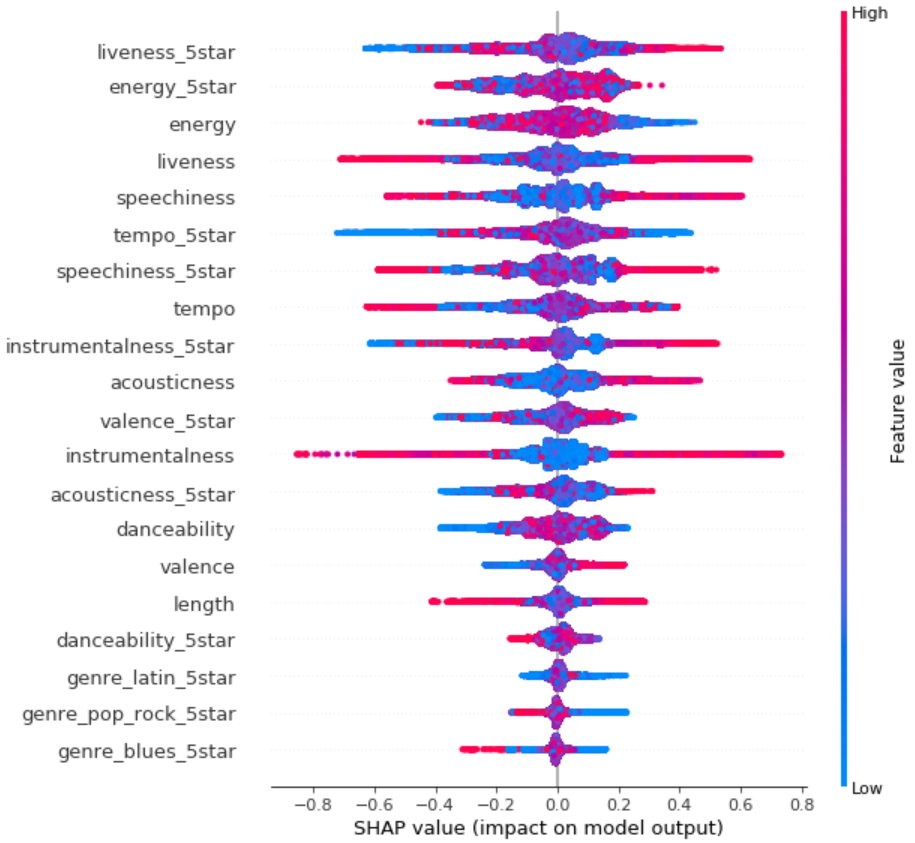

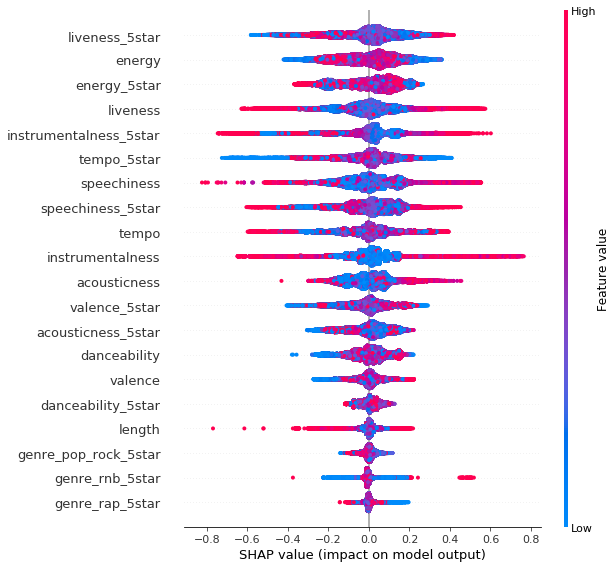

In [68]:
X_train = train.iloc[:, 1:]
shap.summary_plot(shap_no_base, X_train)

<a id='03-lineage'></a>

## Examine Lineage

##### [back to top](#03-nb)

----
Though you already know the training job details from above, if we were just given the model uri, we could use SageMaker Lineage to produce the training job details which produced the model.

### Data Lineage and Metrics for Best Model

In [69]:
from sagemaker.lineage import context, artifact, association, action

### Training data artifact

In [70]:
data_artifact_list = []
for data_input in training_job_info['InputDataConfig']:
    channel = data_input['ChannelName']
    data_s3_uri = data_input['DataSource']['S3DataSource']['S3Uri']

    matching_artifacts = list(artifact.Artifact.list(
        source_uri=data_s3_uri,
        sagemaker_session=sagemaker_session)
    )
    
    if matching_artifacts:
        data_artifact = matching_artifacts[0]
        print(f'Using existing artifact: {data_artifact.artifact_arn}')
    else:
        data_artifact = artifact.Artifact.create(
            artifact_name=channel,
            source_uri=data_s3_uri,
            artifact_type='Dataset',
            sagemaker_session=sagemaker_session)
        print(f'Create artifact {data_artifact.artifact_arn}: SUCCESSFUL')
    data_artifact_list.append(data_artifact)

Using existing artifact: arn:aws:sagemaker:us-east-2:738335684114:artifact/a60ca2ef304b154ae3e3f28f4ac611a1
Using existing artifact: arn:aws:sagemaker:us-east-2:738335684114:artifact/ffcb05539920cdd38bb39b76a2645628


### Model artifact

In [71]:
trained_model_s3_uri = training_job_info['ModelArtifacts']['S3ModelArtifacts']

matching_artifacts = list(artifact.Artifact.list(
    source_uri=trained_model_s3_uri,
    sagemaker_session=sagemaker_session)
)

if matching_artifacts:
    model_artifact = matching_artifacts[0]
    print(f'Using existing artifact: {model_artifact.artifact_arn}')
else:
    model_artifact = artifact.Artifact.create(
        artifact_name='TrainedModel',
        source_uri=trained_model_s3_uri,
        artifact_type='Model',
        sagemaker_session=sagemaker_session)
    print(f'Create artifact {model_artifact.artifact_arn}: SUCCESSFUL')

Using existing artifact: arn:aws:sagemaker:us-east-2:738335684114:artifact/73e209fdadebcb406cedbafc4e7cbc46


#### Set artifact associations

In [72]:
trial_component = sagemaker_client.describe_trial_component(TrialComponentName=training_job_info['TrainingJobName']+'-aws-training-job')
trial_component_arn = trial_component['TrialComponentArn']

#### Store artifacts

In [73]:
artifact_list = data_artifact_list + [model_artifact]

for artif in artifact_list:
    if artif.artifact_type == 'Dataset':
        assoc = 'ContributedTo'
    else:
        assoc = 'Produced'
    try:
        association.Association.create(
            source_arn=artif.artifact_arn,
            destination_arn=trial_component_arn,
            association_type=assoc,
            sagemaker_session=sagemaker_session)
        print(f"Association with {artif.artifact_type}: SUCCESSFUL")
    except:
        print(f"Association already exists with {artif.artifact_type}")

Association already exists with DataSet
Association already exists with DataSet
Association with Model: SUCCESSFUL


<a id='03-register'></a>

## Model Registry

##### [back to top](#03-nb)

----

In [74]:
mpg_name = prefix+'-notebooks'

ps.add({'mpg_name':mpg_name}, namespace='music-rec')
ps.store()

date and time = 05/08/2021 06:31:13


In [75]:



model_packages = sagemaker_client.list_model_packages(ModelPackageGroupName=mpg_name)['ModelPackageSummaryList']

if model_packages:
    print(f'Using existing Model Package Group: {mpg_name}')
else:
    mpg_input_dict = {
        'ModelPackageGroupName': mpg_name,
        'ModelPackageGroupDescription': 'Music Recommendation Models'
    }

    mpg_response = sagemaker_client.create_model_package_group(**mpg_input_dict)
    print(f'Create Model Package Group {mpg_name}: SUCCESSFUL')

Create Model Package Group music-recommendation-notebooks: SUCCESSFUL


In [76]:
sys.path.insert(1, './code')
from inference_specification import InferenceSpecification

model_uri = training_job_info.get('ModelArtifacts', {}).get('S3ModelArtifacts')
training_image = training_job_info['AlgorithmSpecification']['TrainingImage']

mp_inference_spec = InferenceSpecification().get_inference_specification_dict(
    ecr_image=training_image,
    supports_gpu=False,
    supported_content_types=['text/csv'],
    supported_mime_types=['text/csv'])

mp_inference_spec['InferenceSpecification']['Containers'][0]['ModelDataUrl'] = model_uri
mp_input_dict = {
    'ModelPackageGroupName': mpg_name,
    'ModelPackageDescription': 'SageMaker Music Recommender',
    'ModelApprovalStatus': 'PendingManualApproval'
}

mp_input_dict.update(mp_inference_spec)
mp_response = sagemaker_client.create_model_package(**mp_input_dict)
    
model_packages = sagemaker_client.list_model_packages(ModelPackageGroupName=mpg_name)['ModelPackageSummaryList']
model_packages

[{'ModelPackageGroupName': 'music-recommendation-notebooks',
  'ModelPackageVersion': 1,
  'ModelPackageArn': 'arn:aws:sagemaker:us-east-2:738335684114:model-package/music-recommendation-notebooks/1',
  'ModelPackageDescription': 'SageMaker Music Recommender',
  'CreationTime': datetime.datetime(2021, 8, 5, 6, 31, 13, 909000, tzinfo=tzlocal()),
  'ModelPackageStatus': 'Completed',
  'ModelApprovalStatus': 'PendingManualApproval'}]

## Create Model from Estimator

In [77]:
model_matches = sagemaker_client.list_models(NameContains=model_name)['Models']

for model_name_match in model_matches:
    sagemaker_session.delete_model(model_name_match['ModelName'])
    print(f"Deleted existing model: {model_name_match['ModelName']}")
    
model = sagemaker_session.create_model_from_job(
    name=model_name,
    training_job_name=training_job_name,
    role=sagemaker_role,
    image_uri=training_job_info['AlgorithmSpecification']['TrainingImage']
)

